In [43]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
import sys
sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import xarray as xr 

from shapely import wkt
from datetime import datetime
import datacube

from matplotlib.cm import RdYlGn, Greens

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
#import datacube utilities
import utils_dcal.data_cube_utilities.data_access_api as dc_api  
from utils_dcal.data_cube_utilities.dc_display_map import display_map
from utils_dcal.data_cube_utilities.dc_mosaic import create_max_ndvi_mosaic, create_median_mosaic, create_mosaic
from utils_sac.createAOI import create_lat_lon
from utils_sac.createindices import NDVI
from utils_sac.clean_mask import landsat_qa_clean_mask


In [45]:
api = dc_api.DataAccessApi()
dc = datacube.Datacube(app='ndvi anomoly')

In [46]:
aoi_wkt = "POLYGON((178.98101806642 -17.592544555664, 179.03903961183 -17.593231201171, 179.03903961183 -17.66258239746, 178.97998809815 -17.661209106445, 178.98101806642 -17.592544555664))"
output_projection = "EPSG:32760"
resolution = (-30, 30)
platform = 'SENTINEL_2'

In [47]:
# Select the baseline time period (start and end)
baseline_time_period = (datetime(2019,1,1), datetime(2019,2,1))

In [48]:
# Select the cloud-free mosaic type
# Options are: max_ndvi, median, most_recent_pixel
mosaic_type = "max_ndvi"

In [49]:
# Select NDVI Anomaly Threshold Range
# We are looking for pixels that have lost significant vegetation
# NDVI losses are typically 0.1 or more for deforestation

minimum_change = -0.7
maximum_change = -0.2

In [50]:
#Create AOI

In [51]:
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [52]:
## The code below renders a map that can be used to orient yourself with the region.
display_map(latitude = lat_extents, longitude = lon_extents)

In [53]:
if platform  in ["SENTINEL_2"]:
    product = 's2_esa_sr_granule'
    measurements = ["green","red","blue","nir","swir_1","swir_2","coastal_aerosol","scene_classification"]
elif platform in ["LANDSAT_8"]:    
    measurements = ["red", "green", "blue", "nir", "swir1", "swir2", "pixel_qa"]
    product = 'ls8_usgs_sr_scene'
else:
    print("invalid platform")

In [54]:
# Create the 'query' dictionary object, which contains the longitudes, latitudes 
query = {
    'y': lat_extents,
    'x': lon_extents,
    'output_crs': output_projection,  
    'resolution': resolution,
    'product' : product,
    'platform' : platform, 
    'measurements' : measurements
}

In [55]:
baseline_ds = dc.load(
    time = baseline_time_period,
    **query
)


### Check if loads are valid

In [56]:
def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

In [57]:
if is_dataset_empty(baseline_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Baseline Dataset!")

In [58]:

#create cloud mask
baseline_clean_mask = landsat_qa_clean_mask(baseline_ds, platform)


In [59]:
baseline_ds = baseline_ds.where(baseline_clean_mask)

In [60]:
mosaic_function = {"median": create_median_mosaic,
                   "max_ndvi": create_max_ndvi_mosaic,
                   "most_recent_pixel": create_mosaic}

In [61]:
baseline_compositor = mosaic_function[mosaic_type]

In [62]:
baseline_composite = baseline_compositor(baseline_ds, clean_mask = baseline_clean_mask)

In [63]:
ndvi_baseline_composite = NDVI(baseline_composite)

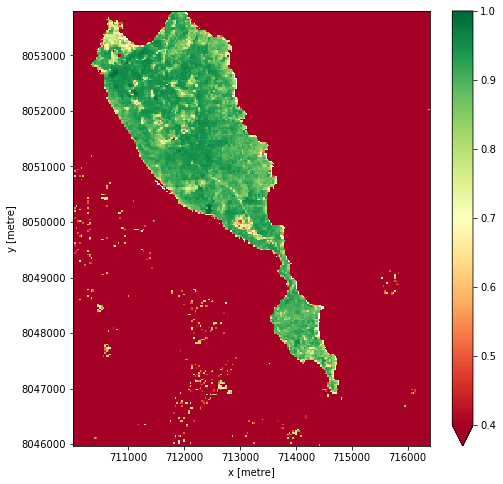

In [64]:
plt.figure(figsize = (8,8))
ndvi_baseline_composite.plot(vmin=0.4, vmax=1, cmap = RdYlGn)